In [32]:
import os
import json
import spacy
from collections import Counter
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import matplotlib.patches as mpatches
import statsmodels.api as sm
import statsmodels.formula.api as smf

#### tagging

In [35]:
nlp = spacy.load("en_core_web_sm")

ALIGNED_DIR = "/workspaces/Gesture-Language-Alignment-in-Instructional-Videos/00_videos/aligned_transcripts"
emphasis_words = {"really", "always", "definitely", "super", "so", "important", "very"}
filler_words = {"uh", "um", "like", "you know", "i mean", "so", "well"}

for filename in os.listdir(ALIGNED_DIR):
    if filename.endswith("_aligned.json"):
        file_path = os.path.join(ALIGNED_DIR, filename)
        with open(file_path, "r") as f:
            data = json.load(f)

        lemma_freq = defaultdict(int)
        lemmatized_segments = []

        for segment in data:
            doc = nlp(segment["text"])
            lemmas = [token.lemma_.lower() for token in doc if not token.is_punct and not token.is_stop]
            lemmatized_segments.append(lemmas)
            for lemma in set(lemmas):
                lemma_freq[lemma] += 1

        for i, segment in enumerate(data):
            text = segment["text"]
            doc = nlp(text)

            segment["pos_tags"] = [(token.text, token.pos_) for token in doc]
            segment["pos_counts"] = dict(Counter(token.pos_ for token in doc))

            lemmas = lemmatized_segments[i]
            repeated = [lemma for lemma in lemmas if lemma_freq[lemma] > 1]
            segment["repeated_lemmas"] = repeated
            segment["is_repetition"] = bool(repeated)

            has_imperative = any(
                token.pos_ == "VERB" and token.dep_ == "ROOT" and not any(
                    child.dep_ == "nsubj" for child in token.children
                ) for token in doc
            )

            imperative_type = "none"
            for token in doc:
                if token.pos_ == "VERB" and token.dep_ == "ROOT" and not any(child.dep_ == "nsubj" for child in token.children):
                    has_object = any(child.dep_ in {"dobj", "obj"} for child in token.children)
                    imperative_type = "procedural" if has_object else "directive"
                    break

            words = [token.text for token in doc if token.is_alpha]
            word_lengths = [len(word) for word in words]
            avg_word_length = sum(word_lengths) / len(word_lengths) if word_lengths else 0
            emphasis_used = any(token.lemma_.lower() in emphasis_words for token in doc)

            num_conj = sum(1 for token in doc if token.dep_ in {"cc", "conj"})
            sub_clauses = sum(1 for token in doc if token.dep_ in {"advcl", "ccomp", "mark"})
            avg_depth = sum(abs(token.head.i - token.i) for token in doc if token != token.head) / len(doc)
            filler_count = sum(1 for token in doc if token.text.lower() in filler_words)
            noun_count = sum(1 for token in doc if token.pos_ == "NOUN")
            pron_count = sum(1 for token in doc if token.pos_ == "PRON")
            noun_pron_ratio = noun_count / pron_count if pron_count > 0 else noun_count

            segment["has_imperative"] = int(has_imperative)
            segment["imperative_type"] = imperative_type
            segment["avg_word_length"] = avg_word_length
            segment["word_count"] = len(words)
            segment["uses_emphasis_word"] = int(emphasis_used)
            segment["num_conjunctions"] = num_conj
            segment["subordinate_clauses"] = sub_clauses
            segment["avg_token_depth"] = avg_depth
            segment["filler_word_count"] = filler_count
            segment["noun_to_pronoun_ratio"] = noun_pron_ratio

        with open(file_path, "w") as f:
            json.dump(data, f, indent=2)

        print(f"✅ Fully enriched: {filename}")


✅ Fully enriched: EasyBlueberryMuffinsRecipe_aligned.json
✅ Fully enriched: PerfectWeeknightShrimpFriedRice_aligned.json
✅ Fully enriched: PeruvianChickenRecipe_aligned.json
✅ Fully enriched: InasFavoriteThings_aligned.json


#### visualizing 

/tmp/ipykernel_1597/774626215.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Rectangle((i, 0), 1, 1, color=color, edgecolor=edgecolor, linewidth=1.5 if is_repeat else 0.5)
/tmp/ipykernel_1597/774626215.py:35: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


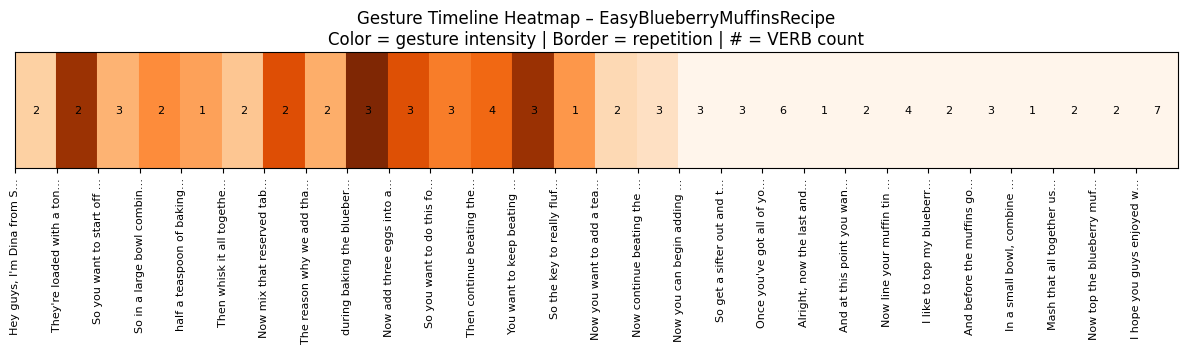

In [13]:

ALIGNED_DIR = "/workspaces/Gesture-Language-Alignment-in-Instructional-Videos/00_videos/aligned_transcripts"

def plot_segment_timeline_heatmap(base_name, highlight_pos="VERB"):
    file_path = os.path.join(ALIGNED_DIR, f"{base_name}_aligned.json")

    with open(file_path, "r") as f:
        data = json.load(f)

    num_segments = len(data)
    gesture_vals = [seg["gesture_avg"] for seg in data]
    repetitions = [seg.get("is_repetition", False) for seg in data]
    pos_counts = [seg.get("pos_counts", {}).get(highlight_pos, 0) for seg in data]
    texts = [seg["text"][:25] + "…" if len(seg["text"]) > 25 else seg["text"] for seg in data]

    norm = mcolors.Normalize(vmin=min(gesture_vals), vmax=max(gesture_vals))
    cmap = plt.cm.Oranges

    fig, ax = plt.subplots(figsize=(15, 1.5))
    for i, (gesture, is_repeat, pos_count) in enumerate(zip(gesture_vals, repetitions, pos_counts)):
        color = cmap(norm(gesture))
        edgecolor = "black" if is_repeat else "none"
        ax.add_patch(
            mpatches.Rectangle((i, 0), 1, 1, color=color, edgecolor=edgecolor, linewidth=1.5 if is_repeat else 0.5)
        )
        if pos_count > 0:
            ax.text(i + 0.5, 0.5, str(pos_count), ha="center", va="center", fontsize=8, color="black")

    ax.set_xlim(0, num_segments)
    ax.set_ylim(0, 1)
    ax.set_xticks(range(num_segments))
    ax.set_xticklabels(texts, rotation=90, fontsize=8)
    ax.set_yticks([])
    ax.set_title(f"Gesture Timeline Heatmap – {base_name}\nColor = gesture intensity | Border = repetition | # = {highlight_pos} count")

    plt.tight_layout()
    plt.show()

# Example
plot_segment_timeline_heatmap("EasyBlueberryMuffinsRecipe", highlight_pos="VERB")

In [36]:
def load_all_videos_features():
    rows = []
    for filename in os.listdir(ALIGNED_DIR):
        if filename.endswith("_aligned.json"):
            base_name = filename.replace("_aligned.json", "")
            file_path = os.path.join(ALIGNED_DIR, filename)

            with open(file_path, "r") as f:
                data = json.load(f)

            for seg in data:
                row = {
                    "video_name": base_name,
                    "text": seg["text"],
                    "gesture_avg": seg.get("gesture_avg", 0),
                    "is_repetition": int(seg.get("is_repetition", False)),
                    "verb_count": seg.get("pos_counts", {}).get("VERB", 0),
                    "adv_count": seg.get("pos_counts", {}).get("ADV", 0),
                    "intj_count": seg.get("pos_counts", {}).get("INTJ", 0),
                    "segment_length": seg["end_time"] - seg["start_time"],
                    "has_imperative": seg.get("has_imperative", 0),
                    "avg_word_length": seg.get("avg_word_length", 0),
                    "word_count": seg.get("word_count", 0),
                    "uses_emphasis_word": seg.get("uses_emphasis_word", 0),
                    "num_conjunctions": seg.get("num_conjunctions", 0),
                    "subordinate_clauses": seg.get("subordinate_clauses", 0),
                    "avg_token_depth": seg.get("avg_token_depth", 0),
                    "filler_word_count": seg.get("filler_word_count", 0),
                    "noun_to_pronoun_ratio": seg.get("noun_to_pronoun_ratio", 0),
                    "imperative_type": seg.get("imperative_type", "none")
                }
                rows.append(row)

    return pd.DataFrame(rows)


In [37]:
df_all = load_all_videos_features()

df_all = pd.get_dummies(df_all, columns=["imperative_type"], drop_first=True)


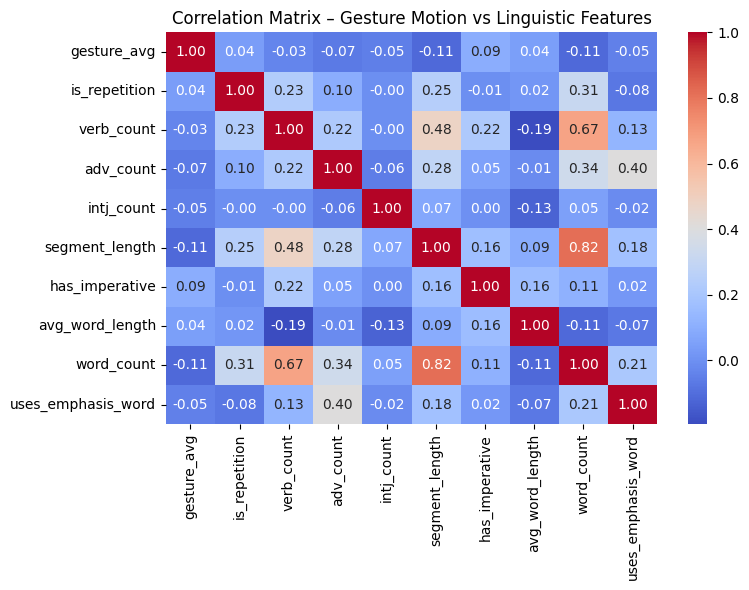

In [30]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_all.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix – Gesture Motion vs Linguistic Features")
plt.tight_layout()
plt.show()


In [38]:
formula = (
    "gesture_avg ~ verb_count + is_repetition + adv_count + intj_count + "
    "segment_length + has_imperative + avg_word_length + word_count + "
    "uses_emphasis_word + num_conjunctions + subordinate_clauses + "
    "avg_token_depth + filler_word_count + noun_to_pronoun_ratio + "
    "imperative_type_directive + imperative_type_procedural + C(video_name)"
)

model = smf.ols(formula=formula, data=df_all).fit()
print(model.summary())



PatsyError: Error evaluating factor: NameError: name 'imperative_type_directive' is not defined
    gesture_avg ~ verb_count + is_repetition + adv_count + intj_count + segment_length + has_imperative + avg_word_length + word_count + uses_emphasis_word + num_conjunctions + subordinate_clauses + avg_token_depth + filler_word_count + noun_to_pronoun_ratio + imperative_type_directive + imperative_type_procedural + C(video_name)
                                                                                                                                                                                                                                                                     ^^^^^^^^^^^^^^^^^^^^^^^^^

In [33]:
print(df_all["video_name"].unique())

formula = "gesture_avg ~ verb_count + is_repetition + adv_count + intj_count + segment_length + has_imperative + avg_word_length + word_count + uses_emphasis_word + C(video_name)"

model_fe = smf.ols(formula=formula, data=df_all).fit()

print(model_fe.summary())

['EasyBlueberryMuffinsRecipe' 'PerfectWeeknightShrimpFriedRice'
 'PeruvianChickenRecipe' 'InasFavoriteThings']
                            OLS Regression Results                            
Dep. Variable:            gesture_avg   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     9.113
Date:                Thu, 17 Apr 2025   Prob (F-statistic):           1.09e-15
Time:                        18:06:20   Log-Likelihood:                 998.55
No. Observations:                 442   AIC:                            -1971.
Df Residuals:                     429   BIC:                            -1918.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [